<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [43]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

 data_labels_extraData.csv	      patch_images      Untitled1.ipynb
 data_labels_mainData.csv	      Untitled	       'Untitled8 (1).ipynb'
'Image_classification_data (1).zip'   Untitled0.ipynb   Untitled8.ipynb


In [ ]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data (1).zip' .
!unzip -q -o 'Image_classification_data (1).zip'
!rm 'Image_classification_data (1).zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [ ]:
#Uncomment if on loca machine or AWS
# import zipfile
# with zipfile.ZipFile('./Image_classification_data (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('./')
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4


# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [ ]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 50

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
from tensorflow.python.keras.metrics import Metric

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy',get_f1])

In [ ]:
history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25)

119/119 [==============================] - 34s 35ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.4886 - get_f1: 1.2176 - val_loss: 0.9793 - val_sparse_categorical_accuracy: 0.5766 - val_get_f1: 1.1997
Epoch 2/25
119/119 [==============================] - 4s 29ms/step - loss: 0.8393 - sparse_categorical_accuracy: 0.6742 - get_f1: 1.1341 - val_loss: 0.8086 - val_sparse_categorical_accuracy: 0.6842 - val_get_f1: 1.1500
Epoch 3/25
119/119 [==============================] - 4s 30ms/step - loss: 0.7652 - sparse_categorical_accuracy: 0.7014 - get_f1: 1.1659 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.6993 - val_get_f1: 1.0959
Epoch 4/25
119/119 [==============================] - 4s 30ms/step - loss: 0.7293 - sparse_categorical_accuracy: 0.7118 - get_f1: 1.1488 - val_loss: 0.8516 - val_sparse_categorical_accuracy: 0.6478 - val_get_f1: 1.2007
Epoch 5/25
119/119 [==============================] - 4s 30ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.7229 - get_f1: 1.16

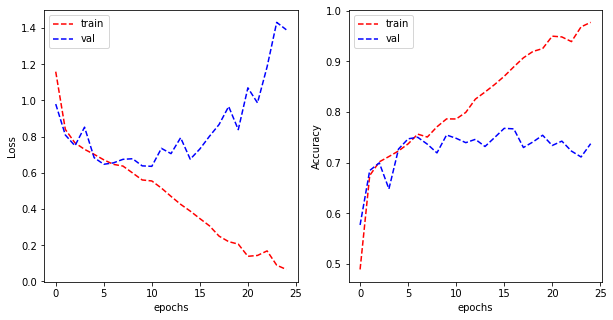

In [ ]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['sparse_categorical_accuracy'], history_VGG_1.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=100)
plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['sparse_categorical_accuracy'], history_VGG_2.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_2.evaluate(validation_generator)

40/40 [==============================] - 1s 19ms/step - loss: 1.4398 - sparse_categorical_accuracy: 0.7458


[1.4398329257965088, 0.7458312511444092]

In [ ]:
test_data['Class'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [77]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [78]:
reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    # tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
    #                        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
    #                        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [79]:

model_VGG_3.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model_VGG_3.optimizer.get_config()

Epoch 1/100
220/220 [==============================] - 6s 27ms/step - loss: 1.3130 - sparse_categorical_accuracy: 0.4713 - val_loss: 1.1839 - val_sparse_categorical_accuracy: 0.5093
Epoch 2/100
220/220 [==============================] - 6s 25ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.0530 - val_sparse_categorical_accuracy: 0.5882
Epoch 3/100
220/220 [==============================] - 6s 25ms/step - loss: 1.0412 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.6337
Epoch 4/100
220/220 [==============================] - 6s 25ms/step - loss: 0.9843 - sparse_categorical_accuracy: 0.6375 - val_loss: 0.9384 - val_sparse_categorical_accuracy: 0.6433
Epoch 5/100
220/220 [==============================] - 6s 25ms/step - loss: 0.9608 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.6609
Epoch 6/100
220/220 [==============================] - 6s 25ms/step - loss: 0.9414 - spars

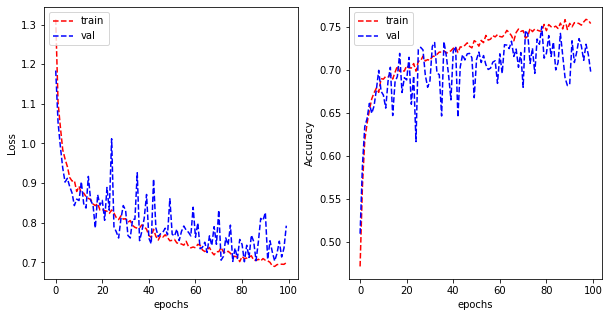

In [80]:
history_VGG_3 = model_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=100)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['sparse_categorical_accuracy'], history_VGG_3.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model_VGG_3.evaluate(validation_generator)

74/74 [==============================] - 1s 11ms/step - loss: 0.7381 - sparse_categorical_accuracy: 0.7433


[0.7381166815757751, 0.7433046698570251]

In [4]:
tf.metrics.F1Score(
    num_classes: tf.types.FloatTensorLike,
    average: str = None,
    threshold: Optional[FloatTensorLike] = None,
    name: str = 'f1_score',
    dtype: tf.types.AcceptableDTypes = None
)

SyntaxError: ignored

In [ ]:

# setup data generator (may have done this before)
# batch_size_ = 1
# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=val_data,
#         directory='./',
#         x_col="ImgPath",
#         y_col="Class",
#         target_size=(32, 32),
#         batch_size=batch_size_,
#         class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

NameError: ignored